In [1]:
%cd ../../.
from workflow.modules import *
import sklearn as sk, sklearn.preprocessing, sklearn.metrics

/cluster/project/beltrao/jjaenes/23.03_DHODH


In [2]:
# Choose method to plot
method_name_ = 'DiffDock'
#method_name_ = 'vina'

df_ = pd.read_csv(f'results/raw_docking_scores_{method_name_}.tsv', sep='\t')

In [3]:
def label_id_(r):
    if r['library_id'] == 'dude_actives':
        return 'DUDE actives'
    elif r['library_id'].startswith('dude_decoys'):
        return 'DUDE decoys'
    elif r['library_id'].startswith('prestwick'):
        if r.ligand_id in {'teriflunomide', 'tiratricol', 'dicumarol'}:
            return 'in_vitro_active'
        elif r.ligand_id in {'leflunomide', 'azaribine', 'tegaserod_maleate', 'flunarizine_dihydrochloride', 'felodipine', 'cisatracurium_besylate', 'mesoridazine_besylate', 'amethopterin'}:
            return 'in_vitro_inactive'
        else:
            return 'Prestwick'
    else:
        return 'Unknown'

df_['label_id'] = df_.apply(label_id_, axis=1)
print(df_['label_id'].value_counts())

label_id
DUDE decoys          6444
Prestwick            1476
DUDE actives          111
in_vitro_inactive       8
in_vitro_active         3
Name: count, dtype: int64


In [4]:
for pdb_id in ['1d3g', '1d3h', '4igh', '6j3c']:
    score_col_ = f'docking_score_{pdb_id}'
    scaler_ = sklearn.preprocessing.RobustScaler().fit(df_.query('label_id == "Prestwick"')[score_col_].to_numpy().reshape(-1, 1))
    df_[score_col_] = scaler_.transform(df_[score_col_].to_numpy().reshape(-1, 1))
df_

,ligand_id,library_id,docking_score_1d3g,docking_score_1d3h,docking_score_4igh,docking_score_6j3c,label_id
0,CHEMBL104001,dude_actives,2.845082,1.437503,1.808002,2.508283,DUDE actives
1,CHEMBL107642,dude_actives,2.719386,-0.815275,1.052445,2.221207,DUDE actives
2,CHEMBL41799,dude_actives,3.815615,1.414756,2.074270,1.073455,DUDE actives
3,CHEMBL39448,dude_actives,3.594265,1.537032,1.953160,3.518149,DUDE actives
4,CHEMBL142996,dude_actives,2.173816,1.492498,1.851271,2.452923,DUDE actives
...,...,...,...,...,...,...,...
8037,troleandomycin,prestwick_c,0.085040,0.984957,0.859423,0.131867,Prestwick
8038,colistin_sulfate,prestwick_c,-1.171916,-1.179155,-0.425947,-0.682864,Prestwick
8039,cyclosporin_a,prestwick_c,-1.195172,0.621070,-0.464957,-1.123533,Prestwick
8040,vancomycin_hydrochloride,prestwick_c,0.065695,-1.194204,-1.174475,-1.139471,Prestwick


In [5]:
cols_ = [f'docking_score_{pdb_id}' for pdb_id in ['1d3g', '1d3h', '4igh', '6j3c'] ]
df_['docking_score_combined'] = df_[cols_].mean(axis=1)

0.8519706857695685


Text(0.5, 1.0, 'DiffDock (DUDE AUC=85.2)')

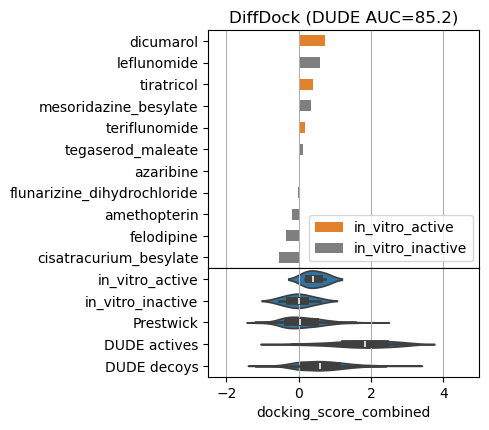

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.5,4.5), gridspec_kw={'height_ratios': [11, 5]})
fig.subplots_adjust(hspace=0)

kwargs_ = {
    'palette': {
        'in_vitro_active': 'tab:orange',
        'in_vitro_inactive': 'tab:gray',
    }
}

df_invitro_ = df_.query('label_id == "in_vitro_inactive" | label_id == "in_vitro_active"').sort_values('docking_score_combined', ascending=False)
sns.barplot(data=df_invitro_, x='docking_score_combined', y='ligand_id', hue='label_id', width=.5, ax=ax[0], **kwargs_)
ax[0].legend(loc='lower right')

kwargs_ = {
    'order': [
        'in_vitro_active',
        'in_vitro_inactive',
        'Prestwick',
        'DUDE actives',
        'DUDE decoys',
    ],
    'orient': 'h',
    #'inner': 'stick',
    #'cut': 0,
}
sns.violinplot(data=df_, x='docking_score_combined', y='label_id', **kwargs_)
ax[0].set_xlim([-2.5, 5])
ax[0].xaxis.grid(True)
ax[1].xaxis.grid(True)
ax[0].set_ylabel('')
ax[1].set_ylabel('')

df_auc_ = df_.query('label_id == "DUDE actives" | label_id == "DUDE decoys"')
auc_ = sk.metrics.roc_auc_score(y_true=df_auc_['label_id'] == 'DUDE actives', y_score=df_auc_['docking_score_combined'])
print(auc_)
ax[0].set_title(f'{method_name_} (DUDE AUC={100*auc_:.1f})')
#plt.savefig(f'results/scoreplot_{method_name_}.svg', bbox_inches='tight', transparent=True)

In [7]:
#df_table_ = df1_.merge(df2_, on='ligand_id')[['ligand_id', 'label_id', 'docking_score_vina', 'docking_score_diffdock']]\
#    .sort_values('docking_score_diffdock', ascending=False)
#df_table_.drop_duplicates(keep='first').to_csv('results/docking_scores.tsv', sep='\t', index=False, header=True)